In [1]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
from working_with_files import *
from preprocessing import *
import nltk
from datetime import datetime
from collections import Counter
from string import punctuation
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

### All preprocessing functions

In [123]:
# split corpus into 2 corpora by 2014
def sort_json_for_semantic_shifts(corpus):
    subcorpus = [] # < 2014
    # subcorpus2 = corpus >= 2014
    split_date = datetime.strptime('01-01-2014', '%d-%m-%Y').date()
    for text_data in corpus:
        if text_data['id'] not in [8079, 10995, 11494, 11848, 11854, 11858, 26987, 30920]:
            try:
                date = datetime.strptime(text_data['date'].strip(), '%d-%m-%Y').date()
            except ValueError:
                date = datetime.strptime(text_data['date'], '%m-%Y').date()
            if date < split_date:
                subcorpus.append(text_data)
    return subcorpus, corpus

# build vocabulary and train word2vec model
def build_w2v_model(corpus, min_count):
    documents = []
    for text_data in corpus:
        documents.extend(tokenize_text(text_data['lemmas']))
    w2v_model = gensim.models.Word2Vec(documents, size=300, window=5, min_count=min_count)
    return w2v_model

# tokenize text into list of lists for building w2v model
def tokenize_text(lemmas):
    stopwords = set(get_lexicon_from_file('ru_stopwords_extended.txt'))
    text = ' '.join(lemmas)
    sentences = sent_tokenize(text)
    sentences_tokenized = []
    for sentence in sentences:
        words = [token for token in word_tokenize(sentence) if token.isalpha() and token.isascii() == False 
                 and len(token) > 2 and token not in stopwords]
        if words != []:
            sentences_tokenized.append(words)
    return sentences_tokenized

# check if word in w2v-vocab
def check_if_word_in_vocab(model, word):
    return word in model.wv.vocab

# check how many input models vocabs contain input word 
def get_num_entries(word, models):
    num_entries = 0
    for model in models:
        if check_if_word_in_vocab(model, word):
            num_entries += 1
    return num_entries

# get jaccard similarity for two lists of words
def jaccard_similarity(list1, list2):
    s1, s2 = set(list1), set(list2)
    return len(s1 & s2) / len(s1 | s2)

# get w2v semantic associates
def get_most_similar_list(model, word, topn):
    return list(dict(model.wv.most_similar(positive=word, topn=topn)).keys())

# get semantic shift for every word
def detect_semantic_shifts(models, topn, num_top_shifts):
    # get words relative dfs to further exclude rare words from the result
    freq_dict = get_json_from_file('freq_dict.json')
    # join models vocabs
    joint_vocab = [] 
    for model in models:
        joint_vocab.extend(list(model.wv.vocab))
    # make new vocab containing only words appearing in both models vocabs
    vocab = [word for word in joint_vocab if get_num_entries(word, models) == len(models)]
    associates_dicts = []
    # get semantic associates for every model & every word in vocab
    for model in models:
        associates_dict = {}
        for word in vocab:
            if freq_dict[word] >= 0.005 and freq_dict[word] < 0.85:
                associates_dict[word] = get_most_similar_list(model, word, topn)
        associates_dicts.append(associates_dict)
        
    # get jaccard distance for every word in vocab
    jacc_similarities = {}
    if len(models) == 2:
        for word in associates_dicts[0].keys():
            jacc_similarity = jaccard_similarity(associates_dicts[0][word], associates_dicts[1][word])
            jacc_similarities[word] = jacc_similarity
        jacc_similarities_sorted = sorted(jacc_similarities.items(), key=lambda kv: kv[1])
        print(jacc_similarities_sorted[:num_top_shifts])
        return jacc_similarities_sorted
    else:
        indx_to_model = dict(enumerate(models))
        indx_pairs = list(nltk.bigrams(indx_to_model.keys()))
        for pair in indx_pairs:
            for word in associates_dicts[0].keys():
                jacc_similarity = jaccard_similarity(associates_dicts[pair[0]][word], associates_dicts[pair[1]][word])
                if word not in jacc_similarities:
                    jacc_similarities[word] = jacc_similarity    
                else:
                    jacc_similarities[word] += jacc_similarity  
        avg_jacc_similarities = {word: sim/(len(models)-1) for word, sim in jacc_similarities.items()}
        avg_jacc_similarities_sorted = sorted(avg_jacc_similarities.items(), key=lambda kv: kv[1])
        print(avg_jacc_similarities_sorted[:num_top_shifts])
        return avg_jacc_similarities_sorted
    
# get semantic associates for a word in a list of w2v models       
def get_most_similar(word, topn, models):
    print(word.upper(), '\n')
    titles = ['< 2014', '>= 2014']
    indx = 0
    for model in models:
        title = titles[indx]
        try:
            print(title, '\n', model.wv.most_similar(positive=word, topn=topn), '\n')
        except KeyError:
            print(title, '\nNo such word in vocabulary\n')
        indx += 1 

### Read corpus from file & split it into two subcorpora

In [108]:
corpus = get_json_from_file('mfa_texts_rhetoric.json')

In [109]:
subcorpora = sort_json_for_semantic_shifts(corpus)

Get number of texts in every subcorpora

In [112]:
for subcorpus in subcorpora:
    print(len(subcorpus))

18309
34831


### Build w2v model for every subcorpus

In [115]:
models = [build_w2v_model(subcorpus, 15) for subcorpus in subcorpora]

### Get semantic shift for every word in vocabulary

In [122]:
semantic_shifts = detect_semantic_shifts(models, 50, 100)

In [14]:
for k, v in dict(semantic_shifts).items():
    print(k, v)

киевский 0.0
правый 0.010101010101010102
минский 0.02040816326530612
киев 0.02040816326530612
образец 0.02040816326530612
выявлять 0.030927835051546393
умеренный 0.030927835051546393
нелегитимный 0.030927835051546393
кремль 0.030927835051546393
возвращаться 0.041666666666666664
подача 0.041666666666666664
пропагандистский 0.05263157894736842
печально 0.05263157894736842
анкара 0.05263157894736842
избиратель 0.05263157894736842
переворот 0.05263157894736842
крым 0.05263157894736842
предвыборный 0.05263157894736842
недобросовестный 0.06382978723404255
многократно 0.06382978723404255
опровергать 0.06382978723404255
след 0.06382978723404255
ежедневно 0.06382978723404255
остальное 0.06382978723404255
постановка 0.07526881720430108
грань 0.07526881720430108
истинный 0.07526881720430108
кампания 0.07526881720430108
пресловутый 0.07526881720430108
убедительный 0.07526881720430108
мост 0.07526881720430108
конвой 0.07526881720430108
называться 0.07526881720430108
аккредитация 0.07526881720430108

страдание 0.3157894736842105
срочный 0.3157894736842105
обход 0.3157894736842105
вразрез 0.3157894736842105
оппозиционер 0.3157894736842105
посещение 0.3157894736842105
ранее 0.3157894736842105
подрыв 0.3157894736842105
соболезнование 0.3157894736842105
опасность 0.3157894736842105
родные 0.3157894736842105
близкие 0.3157894736842105
пострадать 0.3157894736842105
гибель 0.3157894736842105
межсирийский 0.3157894736842105
очередь 0.3157894736842105
назревать 0.3157894736842105
неприемлемый 0.3157894736842105
неоднократно 0.3157894736842105
обязательный 0.3157894736842105
восстанавливать 0.3157894736842105
крайний 0.3157894736842105
аэропорт 0.3157894736842105
пример 0.3157894736842105
менять 0.3157894736842105
окончательно 0.3157894736842105
исполняться 0.3157894736842105
таиланд 0.3157894736842105
абсолютно 0.3157894736842105
преследование 0.3157894736842105
недавний 0.3157894736842105
саудовский 0.3157894736842105
посланник 0.3157894736842105
надеяться 0.3157894736842105
встречать 0.31

усиливать 0.4084507042253521
компонент 0.4084507042253521
правозащитный 0.4084507042253521
формироваться 0.4084507042253521
игрок 0.4084507042253521
инициатор 0.4084507042253521
природа 0.4084507042253521
зал 0.4084507042253521
своевременный 0.4084507042253521
специфика 0.4084507042253521
спецпосланник 0.4084507042253521
охватывать 0.4084507042253521
пройти 0.4084507042253521
перемена 0.4084507042253521
дефицит 0.4084507042253521
нарабатывать 0.4084507042253521
знаменательный 0.4084507042253521
встречаться 0.4084507042253521
реализоваться 0.4084507042253521
ознакомляться 0.4084507042253521
пленарный 0.4084507042253521
финляндия 0.4084507042253521
неправительственный 0.4084507042253521
присутствовать 0.4084507042253521
противоракетный 0.4084507042253521
коридор 0.4084507042253521
выставка 0.4084507042253521
выстраиваться 0.4084507042253521
координатор 0.4084507042253521
сибирь 0.4084507042253521
приятно 0.4084507042253521
продолжаться 0.42857142857142855
помощь 0.42857142857142855
исход

понимание 0.5384615384615384
ситуация 0.5384615384615384
ближневосточный 0.5384615384615384
тенденция 0.5384615384615384
вклад 0.5384615384615384
современный 0.5384615384615384
мид 0.5384615384615384
уголовный 0.5384615384615384
ход 0.5384615384615384
цель 0.5384615384615384
призывать 0.5384615384615384
представлять 0.5384615384615384
американский 0.5384615384615384
согласованный 0.5384615384615384
глава 0.5384615384615384
интерес 0.5384615384615384
процесс 0.5384615384615384
возрастать 0.5384615384615384
значение 0.5384615384615384
коммюнике 0.5384615384615384
соблюдение 0.5384615384615384
выполнять 0.5384615384615384
осуществлять 0.5384615384615384
нацеливать 0.5384615384615384
резолюция 0.5384615384615384
целое 0.5384615384615384
наблюдатель 0.5384615384615384
отслеживать 0.5384615384615384
высокий 0.5384615384615384
преступность 0.5384615384615384
тема 0.5384615384615384
обстановка 0.5384615384615384
суверенитет 0.5384615384615384
широкий 0.5384615384615384
диалог 0.538461538461538

### Get semantic shift distribution

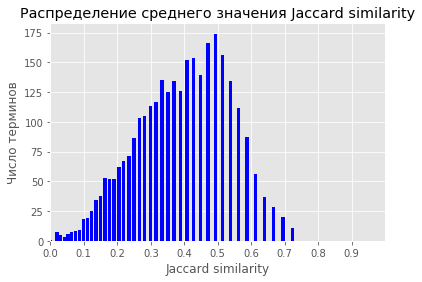

In [68]:
rates = [rate for rate in dict(semantic_shifts).values()]
dist = dict(Counter(rates))
matplotlib.style.use('ggplot')
plt.bar(list(dist.keys()), dist.values(), width=0.01, color='b')
plt.xticks(np.arange(0, 1, 0.1))
plt.xlim(0, 1)
plt.title('Распределение среднего значения Jaccard similarity')
plt.xlabel('Jaccard similarity')
plt.ylabel('Число терминов')
plt.show()

### Get semantic associates for words in top-list

In [15]:
get_most_similar('киевский', 50, models) # от рандомных слов к теме укр кризиса

КИЕВСКИЙ 

< 2014 
 [('коидзуми', 0.8372268676757812), ('покойный', 0.8281340599060059), ('юрьевич', 0.8264502286911011), ('удивляться', 0.8220705986022949), ('позавчера', 0.8209081292152405), ('апрельский', 0.8122836351394653), ('фрадков', 0.8106350898742676), ('янукович', 0.8074126243591309), ('шредер', 0.8074074983596802), ('рамалла', 0.8073036670684814), ('кэмерон', 0.8043939471244812), ('трижды', 0.8042750358581543), ('эхо', 0.8039719462394714), ('продь', 0.8031251430511475), ('араби', 0.8013441562652588), ('косачев', 0.7999714612960815), ('почитать', 0.7977221608161926), ('дубай', 0.7953133583068848), ('мубарак', 0.7945381999015808), ('лужков', 0.7932487726211548), ('суббота', 0.7929078340530396), ('леонид', 0.7922818660736084), ('позвонить', 0.7921439409255981), ('жвания', 0.7916072607040405), ('грызлов', 0.7899907231330872), ('кокойт', 0.7870648503303528), ('юрий', 0.786759614944458), ('ассельборн', 0.7862318754196167), ('воскресение', 0.7841914892196655), ('каракас', 0.7840502

In [16]:
get_most_similar('правый', 50, models) # от темы прав человека (нацменьшинств) к теме националистов, радикалов

ПРАВЫЙ 

< 2014 
 [('нетитульный', 0.7054253816604614), ('негражданин', 0.6980627775192261), ('нацменьшинство', 0.6843544244766235), ('вероисповедание', 0.6785362958908081), ('лишенный', 0.6770936846733093), ('добро', 0.6763871312141418), ('мораль', 0.6761866807937622), ('украинец', 0.6747592687606812), ('попрание', 0.671251654624939), ('лишение', 0.6709274649620056), ('повсеместный', 0.6675716638565063), ('виноватый', 0.6665491461753845), ('этика', 0.6621962785720825), ('достоинство', 0.658099889755249), ('пожилой', 0.6573256254196167), ('элементарный', 0.6556347608566284), ('неалбанский', 0.6547343730926514), ('родиться', 0.6512073278427124), ('плюрализм', 0.6489243507385254), ('нравственность', 0.6477483510971069), ('честность', 0.6476770043373108), ('попирать', 0.6466253399848938), ('русскоговорящий', 0.6448010206222534), ('верующий', 0.6436273455619812), ('объективность', 0.6430827379226685), ('вскрывать', 0.6422837376594543), ('гуманный', 0.6406506299972534), ('трактоваться', 0.6

In [17]:
get_most_similar('минский', 50, models) # от рандомных слов к минским соглашениям

МИНСКИЙ 

< 2014 
 [('сопредседатель', 0.7628496885299683), ('контактный', 0.7385820746421814), ('плюс', 0.7293055057525635), ('мудрец', 0.6626328229904175), ('сопредседательство', 0.6564450263977051), ('рио', 0.6483255624771118), ('председательствовать', 0.5911546945571899), ('сопосредник', 0.5707205533981323), ('брик', 0.5500398874282837), ('постсовет', 0.5388742685317993), ('рик', 0.5334914922714233), ('депутатский', 0.5199314951896667), ('единомышленник', 0.5131089687347412), ('председательствующий', 0.5124715566635132), ('расширенный', 0.5062483549118042), ('довило', 0.5029024481773376), ('мониторинговый', 0.4875379502773285), ('оппозиционный', 0.47891801595687866), ('дублин', 0.47670280933380127), ('кофи', 0.47587504982948303), ('рабочий', 0.47377485036849976), ('франция', 0.4614141881465912), ('спецпредставитель', 0.4613352417945862), ('собираться', 0.46061158180236816), ('лох', 0.45669254660606384), ('постпред', 0.44701772928237915), ('эрне', 0.4463549256324768), ('минус', 0.44

In [18]:
get_most_similar('киев', 50, models) # от рандомных слов к теме укр кризиса

КИЕВ 

< 2014 
 [('сикорский', 0.778502881526947), ('токио', 0.7640303373336792), ('варшава', 0.7622318267822266), ('вильнюс', 0.7549481987953186), ('вчера', 0.7488502264022827), ('минск', 0.7473896741867065), ('попросить', 0.7470910549163818), ('янукович', 0.7403504848480225), ('иванов', 0.7362139225006104), ('буквально', 0.7350183725357056), ('николаевич', 0.7244179248809814), ('михаил', 0.7233294248580933), ('клинтон', 0.7224538326263428), ('керри', 0.7176252007484436), ('позвонить', 0.7137672305107117), ('абуль', 0.7114976644515991), ('прага', 0.710834264755249), ('ашхабад', 0.7108114957809448), ('спрашивать', 0.7105302810668945), ('поинтересоваться', 0.7053464651107788), ('телефон', 0.7053111791610718), ('ющенко', 0.7051494717597961), ('виктор', 0.7037427425384521), ('вестервелла', 0.7031296491622925), ('новость', 0.7003021240234375), ('владимирович', 0.7000618577003479), ('нетерпение', 0.6990625858306885), ('кальми', 0.6985975503921509), ('киевский', 0.6971958875656128), ('гейт',

In [19]:
get_most_similar('образец', 50, models) 
# от образца в значении "образец для подражания" к образцу как образцу какого-либо вещества (дело Скрипалей)

ОБРАЗЕЦ 

< 2014 
 [('капитализм', 0.7097599506378174), ('либеральный', 0.6804692149162292), ('анахронизм', 0.6793736815452576), ('стена', 0.670613169670105), ('исключительность', 0.6700836420059204), ('менталитет', 0.658003032207489), ('столетие', 0.6486126184463501), ('мироощущение', 0.6476662158966064), ('привычный', 0.6464848518371582), ('миф', 0.6400705575942993), ('помеха', 0.6394885778427124), ('символ', 0.6358892917633057), ('нравственность', 0.6349580883979797), ('эмансипация', 0.6331026554107666), ('немыслимый', 0.6317334175109863), ('чума', 0.6316037178039551), ('имперский', 0.629389762878418), ('инстинкт', 0.6269463896751404), ('грань', 0.6267739534378052), ('термин', 0.6217958331108093), ('самодостаточный', 0.6211333870887756), ('достоевский', 0.6208745241165161), ('предрассудок', 0.6202496886253357), ('выстрадать', 0.6158433556556702), ('наслоение', 0.6102281212806702), ('мышление', 0.6065858006477356), ('превосходство', 0.6065263152122498), ('биполярный', 0.6060396432876

In [20]:
get_most_similar('выявлять', 50, models) # от рандомных слов к расследовательской тематике

ВЫЯВЛЯТЬ 

< 2014 
 [('выявляться', 0.6580962538719177), ('расследовать', 0.6267894506454468), ('анализировать', 0.61580890417099), ('реагировать', 0.6074665784835815), ('налицо', 0.6000572443008423), ('вероятный', 0.5920552015304565), ('переламывать', 0.5901573896408081), ('обострять', 0.5898839831352234), ('минимизировать', 0.5879186987876892), ('воспроизводить', 0.5874909162521362), ('устранять', 0.5859382152557373), ('множиться', 0.5835535526275635), ('порождать', 0.5760310888290405), ('выправлять', 0.5745700597763062), ('возникновение', 0.5744912624359131), ('заводить', 0.5740528106689453), ('таить', 0.5719131231307983), ('смягчать', 0.5715771317481995), ('искоренять', 0.5706844925880432), ('разбираться', 0.5658530592918396), ('сталкиваться', 0.5653824210166931), ('раскрывать', 0.5648233890533447), ('прояснивать', 0.5636293888092041), ('сужать', 0.557593047618866), ('покончить', 0.5564517378807068), ('избавлять', 0.5542271137237549), ('минимум', 0.5541901588439941), ('подпитывать'

In [21]:
get_most_similar('умеренный', 50, models) # от умеренных исламистов/оппозиционеров четко к "умеренной сирийской оппозиции"

УМЕРЕННЫЙ 

< 2014 
 [('недальновидный', 0.8132374882698059), ('свершаться', 0.7671678066253662), ('инстинкт', 0.7595237493515015), ('антироссийский', 0.7467684745788574), ('наивный', 0.7438859939575195), ('дискредитировать', 0.7355268001556396), ('здравомыслящий', 0.7280813455581665), ('инерционный', 0.7260244488716125), ('реваншистский', 0.7251361608505249), ('противовес', 0.7232646346092224), ('дальновидный', 0.7225347757339478), ('конфронтационный', 0.71745365858078), ('антиамериканизм', 0.7044855356216431), ('обрекать', 0.7017880082130432), ('бесперспективность', 0.7016736268997192), ('абстрактный', 0.6958789825439453), ('неприкрытый', 0.6947676539421082), ('контрпродуктивно', 0.6927099823951721), ('блоковый', 0.6911449432373047), ('чуждый', 0.6899217963218689), ('падать', 0.689339280128479), ('упасть', 0.6889660954475403), ('доминирующий', 0.6876650452613831), ('нагнетать', 0.6870454549789429), ('пробивать', 0.6855657696723938), ('сознательный', 0.6845275163650513), ('воинственны

In [22]:
def get_texts_by_lemmas(lemmas_to_find, corpus):
    total = 0
    for text_data in corpus:
        n = 0
        all_lemmas = text_data['lemmas']
        for lemma_to_find in lemmas_to_find:
            if lemma_to_find in all_lemmas:
                n += 1
        if n == len(lemmas_to_find):
            print(' '.join(all_lemmas), '\n\n')
            total += 1
    print('total:', total)

In [24]:
get_texts_by_lemmas(['умеренный'], subcorpora[1])

западный  « тройка »  постоянный   член   совет   безопасность   оон   в   лицо   сша ,  великобритания   и   франция   отмечаться   заявление   по   случай   пятилетний   годовщина   трагедия   с   применение   зарина   в   восточный   гута ,  уносить ,  по   разный   оценка ,  жизнь   много   тысяча   мирный   сирийский   гражданин .  в   очередной   раз   в   использование   химоружие   безапелляционно   обвинять   б . асад . 
 вызывать   сожаление ,  что   вашингтон ,  лондон   и   париж   воспользоваться   этот   печальный   для   сирийский   народ   и   весь   мировой   сообщество   дата   в   интерес   продвижение   свой   деструктивный   курс ,  нацеливать   на   дискредитация   президент   сара .  для   это   целый   ряд   западный   и   ближневосточный   государство   не   брезговать   такой   бесчеловечный   провокация ,  как   предпринимать   террорист   по   указка   их   зарубежный   спонсор   химический   атака   в   восточный   гута . 
 для   все ,  включая   независимы

  в   общий  -  да ,  и   это   немало   способствовать   наш   макроэкономический   показатель :  достаточно   высокий   на   фон   общемировой   рост   ввп ,  в   целое   умеренный   и   контролируемый   инфляция ,  дальнейший   наращивание   золотовалютный   запас   цб . 
 однако   в   современный   мир   на   первый   место   стоять   не   количественный   параметр   макроэкономика ,  а   качественный   показатель   социально-экономический   развитие .  особенно   важный   общий   конкурентоспособность   страна ,  ее   инновационный   и   технологический   потенциал ,  роль   в   решение   региональный   и   глобальный   экономический   проблема ,  уровень   и   качество   жизнь   население . 
 на   весь   этот   направление   мы   в   последний   год  -  где-то   большой ,  а   где-то   мало  -  все   же   продвигаться   вперед .  ведущий   отечественный   компания   все   часто   выступать   в   качество   стратегический   инвестор   на   рынок   центральный   и   восточный   евр

In [25]:
get_most_similar('нелегитимный', 50, models) # в разное время разные события называем нелегитимными

НЕЛЕГИТИМНЫЙ 

< 2014 
 [('противоправный', 0.7808340191841125), ('закаев', 0.7790182828903198), ('осуждаться', 0.7763415575027466), ('безосновательный', 0.7720267176628113), ('непростительный', 0.7641289234161377), ('одиозный', 0.7624955177307129), ('неправомерный', 0.7589859366416931), ('преднамеренный', 0.7565850019454956), ('безрассудный', 0.7474210262298584), ('несправедливо', 0.7472245693206787), ('мина', 0.7471860647201538), ('голословный', 0.7471038103103638), ('неуместный', 0.7468651533126831), ('возмутительный', 0.7433986067771912), ('мотивировать', 0.7433890700340271), ('вероломный', 0.7420012950897217), ('обвиняться', 0.739511251449585), ('неизбирательный', 0.7383835315704346), ('запредельный', 0.7376947402954102), ('разгон', 0.7355622053146362), ('пассаж', 0.7352496385574341), ('протестовать', 0.730322003364563), ('приписывать', 0.7293087244033813), ('посчитать', 0.7286850214004517), ('намеренно', 0.7280451059341431), ('смиряться', 0.7269630432128906), ('аморальный', 0.726

In [27]:
get_most_similar('кремль', 50, models) # рандомные слова

КРЕМЛЬ 

< 2014 
 [('владимирович', 0.8831126689910889), ('инаугурация', 0.8622177839279175), ('верительный', 0.8613239526748657), ('владимир', 0.8551682233810425), ('янукович', 0.8532539010047913), ('прага', 0.8514789938926697), ('назарбаев', 0.8481593728065491), ('берлин', 0.8437402248382568), ('варшава', 0.8415025472640991), ('величество', 0.8412128686904907), ('дважды', 0.8343686461448669), ('марта', 0.8333526253700256), ('эдуард', 0.8274267315864563), ('святейшество', 0.8261986970901489), ('вручение', 0.8243315815925598), ('гостеприимный', 0.8202458620071411), ('рим', 0.8195219039916992), ('кирилл', 0.8191266059875488), ('сочи', 0.8183672428131104), ('суббота', 0.8163223266601562), ('оглашать', 0.8136270046234131), ('мюнхен', 0.8134496212005615), ('торжественный', 0.8126095533370972), ('амман', 0.8117974400520325), ('нижний', 0.8111354112625122), ('ориентировочно', 0.81104576587677), ('юрий', 0.8107610940933228), ('патриарх', 0.8097771406173706), ('игорь', 0.8092943429946899), ('в

In [28]:
get_most_similar('возвращаться', 50, models) # от рандомных слов к теме беженцев

ВОЗВРАЩАТЬСЯ 

< 2014 
 [('преподносить', 0.7519655823707581), ('спекулировать', 0.7452181577682495), ('упираться', 0.7351593971252441), ('давить', 0.7333601117134094), ('лишенный', 0.7327585220336914), ('похожий', 0.7265193462371826), ('отнимать', 0.723996102809906), ('потерять', 0.7238954305648804), ('умирать', 0.7216484546661377), ('привыкать', 0.7213560938835144), ('рассуждать', 0.7179194092750549), ('искажать', 0.7159808874130249), ('плохо', 0.7133609056472778), ('втягивать', 0.7130847573280334), ('несправедливый', 0.7110011577606201), ('апеллировать', 0.7106506824493408), ('ковер', 0.7089071869850159), ('подозревать', 0.7066705226898193), ('избавляться', 0.704750657081604), ('виноватый', 0.700589120388031), ('настораживать', 0.7003166079521179), ('жаль', 0.6998823881149292), ('успокаиваться', 0.6982728242874146), ('подгонять', 0.6981102228164673), ('зря', 0.6974942088127136), ('подмечать', 0.6967836022377014), ('смиряться', 0.6948148012161255), ('удерживаться', 0.6942570805549622

In [29]:
get_most_similar('подача', 50, models) # подать документ (заявление) - подавать (преподносить) информацию 

ПОДАЧА 

< 2014 
 [('допуск', 0.8202482461929321), ('упд', 0.8000562191009521), ('въездной', 0.7996876239776611), ('проезд', 0.7996433973312378), ('пассажир', 0.7725722789764404), ('лицензия', 0.7711501121520996), ('выдаваться', 0.7661834955215454), ('изымать', 0.7658767700195312), ('билет', 0.7628079652786255), ('отправлять', 0.7574377059936523), ('аренда', 0.7384225130081177), ('выдача', 0.7363366484642029), ('ярошенко', 0.7361623048782349), ('досмотр', 0.734703779220581), ('автоматически', 0.7326958179473877), ('подавать', 0.7317692041397095), ('задержанный', 0.7313030958175659), ('анкета', 0.7308758497238159), ('бут', 0.7305402159690857), ('арестовывать', 0.7295324802398682), ('осужденный', 0.7246779799461365), ('помещать', 0.7225343585014343), ('оплачивать', 0.7218461036682129), ('многократный', 0.7216185331344604), ('отбывать', 0.7212300300598145), ('въезжать', 0.7209120392799377), ('калининград', 0.719746470451355), ('владелец', 0.7190121412277222), ('загранпаспорт', 0.718516230

In [31]:
get_texts_by_lemmas(['подача'], subcorpora[1])

в   приштина   14   декабрь  « парламент »  принимать   решение   о   трансформация   сила   безопасность   косово   в   полноценный   косовский  « армия » .  этот   шаг   становиться   грубый   нарушение   резолюция   совет   безопасность   оон   1244 ,  направлять   на   серьезный   обострение   обстановка   на   балканы ,  чреватый   рецидив   вооруженный   конфликт   в   регион . 
 вызывать   удивление   риторика   ряд   политик   сша   и   ес ,  высокий   генерал   нато ,  пытаться   убеждать   себя   и   окружать   рассуждение   о   то ,  что   решение   приштина   не   менять   суть   сила   безопасность   косово .  на   дело   речь   идти   об   увеличение   они   численность   вдвое ,  создание   резерв ,  а   главное  –  подмена   существо   сила ,  до   последний   время   выполнять   функция   гражданский   оборона .  при   содействие   сша   и   ряд   страна   нато   уже   вестись   форсированный   подготовка   косовоалбанский   военный ,  наращиваться   поставка   косовар

  мы   неоднократно   разъяснять ,  что   какой-либо   основание   для   предъявление   российский   федерация   требование   о   выплата   компенсация   отсутствовать .  для   мы   этот   вопрос   закрывать   раз   и   навсегда . 
 вызывать   глубокий   сожаление ,  что   нынешний   власть   литва   продолжать   инициировать   недружественный   мы   кампания   на   основа   идеологизированный   установка .  это ,  безусловно ,  не   мочь   не   сказываться   на   атмосфера   российский - литовский   отношение   и   продвижение   в   практический   сотрудничество .  убеждать ,  что   наш   европейский   партнер   не   пойти   на   повод   у   затея   привносить   с   подача   вильнюс   в   диалог   россия - ес   деструктивный   момент . 
 


  основной   внимание   быть   уделять   реформа   европейский   суд   по   право   человек  ( еспча )  в   соответствие   с   решение   конференция   высокий   уровень  « о   будущее   еспча »,  который   состояться   в   рамка   председательство 

In [32]:
get_most_similar('пропагандистский', 50, models) # от просто осуждения к дезинформации в медиапространстве

ПРОПАГАНДИСТСКИЙ 

< 2014 
 [('пропаганда', 0.7788042426109314), ('оправдание', 0.7755017876625061), ('бесчеловечный', 0.7719711065292358), ('бессмысленный', 0.7646120190620422), ('ужасный', 0.7556576132774353), ('преднамеренный', 0.7473521828651428), ('сознательно', 0.746684193611145), ('варварский', 0.7445936799049377), ('кощунственный', 0.7445080280303955), ('злодеяние', 0.7420663833618164), ('громкий', 0.7392699718475342), ('обелять', 0.7387211322784424), ('разжигание', 0.736641526222229), ('агрессивный', 0.7354505062103271), ('возмутительный', 0.7342342138290405), ('необоснованный', 0.7336719036102295), ('непрекращающийся', 0.7315524816513062), ('кровавый', 0.7313861846923828), ('извращать', 0.7298568487167358), ('потакание', 0.7280377745628357), ('потакать', 0.7265645265579224), ('смерть', 0.7220938801765442), ('выпад', 0.7215384244918823), ('запугивание', 0.7166610956192017), ('преступный', 0.7159342765808105), ('агрессор', 0.7157409191131592), ('спланировать', 0.715731620788574

In [33]:
get_most_similar('печально', 50, models) # от рандомных слов к теме защиты от дезинформации, предвзятого отношения

ПЕЧАЛЬНО 

< 2014 
 [('обозреватель', 0.8501881957054138), ('шпигель', 0.8482996225357056), ('домысел', 0.8418946266174316), ('супруга', 0.8411157727241516), ('случайность', 0.8356256484985352), ('эхо', 0.8258543014526367), ('закаев', 0.822541356086731), ('известие', 0.8200482130050659), ('ротфельд', 0.819516658782959), ('рачак', 0.8112649321556091), ('извинять', 0.8108874559402466), ('критик', 0.8102076649665833), ('толпа', 0.8099549412727356), ('прощать', 0.8096245527267456), ('бесчинство', 0.8092423677444458), ('единичный', 0.8074408173561096), ('окрестности', 0.8026520609855652), ('эксцесс', 0.8024587631225586), ('издевательство', 0.8022928237915039), ('звонок', 0.8021154403686523), ('шумиха', 0.8017230033874512), ('телевизор', 0.8013211488723755), ('освенцим', 0.8012975454330444), ('лавр', 0.7994806170463562), ('почитать', 0.7985635995864868), ('удивительно', 0.7975445985794067), ('пятеро', 0.7971073389053345), ('потрясать', 0.7965784072875977), ('картинка', 0.7953861951828003), (

In [87]:
get_texts_by_lemmas(['печально'], subcorpora[0])

осуществлять   новый   ядерный   испытание ,  пхеньян   в   очередной   раз   проигнорировать   норма   международный   право ,  продемонстрировать   пренебрежение   решение   СБ   оон .  подобный   поведение ,  несовместимый   с   общепринятый   критерий   мировой   общежитие ,  несомненно ,  заслуживать   осуждение   и   адекватный   реакция   со   сторона   международный   сообщество .  вдвойне   печально ,  что   речь   идти   о   государство ,  с   который   наш   страна   связывать   долгий   история   добрососедство . 
 настаивать   на   то ,  чтобы   кндр   прекращать   противоправный   действие ,  неукоснительно   выполнять   весь   предписание   совет   безопасность   оон ,  полностью   отказываться   от   ракетно-ядерный   программа ,  вернуться   в   дняо   и   режим   всеохватный   гарантия   магатэ .  так   и   только   так   кндр   смочь   выходить   из   состояние   фактический   международный   изоляция ,  что   открывать   она   путь   к   участие   в   международный 

In [34]:
get_most_similar('анкара', 50, models) # рандомные слова

АНКАРА 

< 2014 
 [('рамалла', 0.8439318537712097), ('оаэ', 0.8263441324234009), ('юрий', 0.8071495294570923), ('величество', 0.8025612831115723), ('принц', 0.8022083044052124), ('гейт', 0.8021749258041382), ('аэрофлот', 0.7992109060287476), ('лосюков', 0.7989822626113892), ('трижды', 0.7977041006088257), ('дубай', 0.7908406257629395), ('позвонить', 0.7903448343276978), ('прибытие', 0.7899295091629028), ('лужков', 0.7893553972244263), ('абуджа', 0.7892011404037476), ('хоккайдо', 0.7890823483467102), ('абуль', 0.7881906032562256), ('каракас', 0.7858341932296753), ('телефон', 0.7835830450057983), ('звонок', 0.7828021049499512), ('кальми', 0.7814196944236755), ('хургада', 0.7805731296539307), ('скончаться', 0.7801240682601929), ('игорь', 0.779801607131958), ('абдалла', 0.7797980308532715), ('запись', 0.7795762419700623), ('эхо', 0.7782509326934814), ('сообщать', 0.7779349684715271), ('суббота', 0.7771205902099609), ('сан', 0.7761996984481812), ('командировка', 0.7761977910995483), ('телек

In [40]:
get_most_similar('избиратель', 50, models) # от рандомных слов к выборной тематике

ИЗБИРАТЕЛЬ 

< 2014 
 [('гордиться', 0.6753731966018677), ('сын', 0.6720517873764038), ('легионер', 0.665774941444397), ('звание', 0.6632534265518188), ('предок', 0.6587002277374268), ('спартак', 0.6483187675476074), ('брат', 0.645925760269165), ('верующий', 0.642984926700592), ('оканчивать', 0.642099142074585), ('награда', 0.6405165195465088), ('тур', 0.6394859552383423), ('негражданин', 0.6390568017959595), ('кандидат', 0.6371622085571289), ('подсчет', 0.6366722583770752), ('победитель', 0.6360796689987183), ('муниципальный', 0.6352070569992065), ('латышский', 0.6351858973503113), ('ваффен', 0.634941816329956), ('харири', 0.6347732543945312), ('внук', 0.6343214511871338), ('зарегистрировать', 0.6342744827270508), ('сдавать', 0.6342422962188721), ('двое', 0.6331180334091187), ('девушка', 0.6330656409263611), ('последователь', 0.6320866346359253), ('неизвестный', 0.629749596118927), ('ученик', 0.6288902163505554), ('национальность', 0.6266455054283142), ('удостоить', 0.626142144203186)

In [52]:
get_most_similar('переворот', 50, models) # от разных госпереворотов к украинской теме

ПЕРЕВОРОТ 

< 2014 
 [('служащий', 0.8392813205718994), ('символика', 0.6883950233459473), ('устройство', 0.6846789717674255), ('преступник', 0.6330773234367371), ('ансамбль', 0.617470920085907), ('патруль', 0.6159423589706421), ('воссоздание', 0.6150665283203125), ('городок', 0.6041331887245178), ('награда', 0.6020214557647705), ('совершаться', 0.5933287143707275), ('приготовление', 0.5921920537948608), ('республиканский', 0.5918416380882263), ('бомбардировка', 0.5912810564041138), ('атаковать', 0.5889184474945068), ('танец', 0.5867884159088135), ('парад', 0.583785891532898), ('муж', 0.5831848382949829), ('вторжение', 0.5812348127365112), ('полумесяц', 0.5804104804992676), ('дума', 0.5781230926513672), ('бесчинство', 0.576976478099823), ('нападать', 0.5736873149871826), ('приказ', 0.5729130506515503), ('полиция', 0.5704166889190674), ('разгромить', 0.5681750178337097), ('здание', 0.5649222135543823), ('бандит', 0.5647705793380737), ('покровитель', 0.5640972256660461), ('удостоить', 0.

In [53]:
get_most_similar('крым', 50, models) # от рандомных тем к теме "воссоединения"

КРЫМ 

< 2014 
 [('югра', 0.7985554933547974), ('село', 0.7977919578552246), ('севастополь', 0.7753123044967651), ('часовня', 0.7703507542610168), ('городок', 0.7691827416419983), ('дагестан', 0.7664168477058411), ('летчик', 0.7642635703086853), ('калифорния', 0.7609926462173462), ('танкер', 0.760196328163147), ('кладбище', 0.7575103044509888), ('клиника', 0.7525228261947632), ('антон', 0.7520334720611572), ('четверо', 0.7490771412849426), ('вмф', 0.7467927932739258), ('сжигать', 0.7465736865997314), ('дивизия', 0.7452729940414429), ('трое', 0.7427682876586914), ('гвинейский', 0.7425907850265503), ('панама', 0.7420658469200134), ('капитан', 0.740068793296814), ('монастырь', 0.7400539517402649), ('удмуртия', 0.7386488914489746), ('дочь', 0.7367360591888428), ('кант', 0.7355364561080933), ('могила', 0.7338712811470032), ('николай', 0.7337639331817627), ('скончаться', 0.7326403856277466), ('якутия', 0.7318981885910034), ('сын', 0.7276825308799744), ('супруга', 0.7267102003097534), ('росс'

In [54]:
get_most_similar('предвыборный', 50, models) # от предвыборной темы к теме дезинформации, антироссийской пропаганды

ПРЕДВЫБОРНЫЙ 

< 2014 
 [('кампания', 0.6852039694786072), ('кощунственный', 0.6521393060684204), ('драматичный', 0.6378575563430786), ('неслучайно', 0.6318761110305786), ('повторяться', 0.624882161617279), ('случайность', 0.6156849265098572), ('фальсифицировать', 0.6133530735969543), ('рассуждать', 0.6092015504837036), ('симптом', 0.6087079048156738), ('раскручивать', 0.6076716184616089), ('крутой', 0.6070252656936646), ('чудовищный', 0.6060059666633606), ('спланировать', 0.605594277381897), ('череда', 0.604412853717804), ('перипетия', 0.6039824485778809), ('драматический', 0.6026846170425415), ('трагический', 0.5972479581832886), ('ужасный', 0.5957337617874146), ('возмутительный', 0.5948107242584229), ('коммунизм', 0.594467043876648), ('непрекращающийся', 0.5907987356185913), ('запоминаться', 0.5888134241104126), ('молчание', 0.5879489183425903), ('тревожный', 0.5864365100860596), ('цинично', 0.5841131806373596), ('параллель', 0.581713080406189), ('неприкрытый', 0.5805455446243286), 

In [77]:
get_most_similar('недобросовестный', 50, models) # более выраженной становится тема дезинформации

НЕДОБРОСОВЕСТНЫЙ 

< 2014 
 [('циничный', 0.7912169694900513), ('искажение', 0.7895716428756714), ('намек', 0.7722893953323364), ('обелять', 0.7689088582992554), ('кощунственный', 0.7685980796813965), ('фальсифицировать', 0.7610540390014648), ('красивый', 0.760666012763977), ('приписывать', 0.7585110664367676), ('чуждый', 0.7580825090408325), ('учить', 0.7572757601737976), ('искажать', 0.7534686326980591), ('националистический', 0.7520464658737183), ('равнозначный', 0.7504286766052246), ('терпеть', 0.7503107786178589), ('переписывание', 0.750097930431366), ('бесчеловечный', 0.7468438148498535), ('отрицание', 0.7468156814575195), ('неверный', 0.7466442584991455), ('вольный', 0.7456119656562805), ('человеконенавистнический', 0.7450079917907715), ('реваншистский', 0.7446367740631104), ('оскорбительный', 0.7441308498382568), ('переписывать', 0.7432323694229126), ('идеологизированный', 0.7414495348930359), ('аморальный', 0.7407460808753967), ('идеологизировать', 0.7402505874633789), ('предн

In [78]:
get_most_similar('многократно', 50, models) # no sense

МНОГОКРАТНО 

< 2014 
 [('уезжать', 0.7519300580024719), ('гейтс', 0.7338008880615234), ('зря', 0.7260479927062988), ('умирать', 0.7233490943908691), ('странно', 0.7213684320449829), ('транслировать', 0.7205610275268555), ('эхо', 0.712122917175293), ('михаил', 0.7109185457229614), ('неправда', 0.7098365426063538), ('расплачиваться', 0.7095270156860352), ('евгений', 0.7091643810272217), ('оправдываться', 0.7067580223083496), ('опровергать', 0.704288899898529), ('скорбь', 0.7025201916694641), ('оспариваться', 0.7003576755523682), ('откровенность', 0.6990439295768738), ('произносить', 0.6984076499938965), ('обозреватель', 0.6983802318572998), ('зуб', 0.697351336479187), ('известие', 0.6967517733573914), ('цитировать', 0.6943511962890625), ('упрек', 0.6927554607391357), ('удивительно', 0.6927047371864319), ('тяжело', 0.6877813935279846), ('навязчивый', 0.6860600709915161), ('виноватый', 0.6854313015937805), ('николаевич', 0.6835175156593323), ('поверять', 0.6827776432037354), ('разница', 0